In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import os


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler


from PIL import Image
from sklearn.model_selection import train_test_split

# custom files
from src.model_scratch import ConvNet
from src.model_transfer import convResnet
from src.dataloader import FlowerDataset



In [2]:
DATA_PATH = 'data/'

In [3]:
flower = os.listdir(DATA_PATH)

In [4]:
flower

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
#encoding the labels
label_dict = {flower[i]:i for i in range(len(flower))}


In [6]:
label_dict

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [7]:
dict_flower = {flower[i]: os.listdir(DATA_PATH + flower[i]) for i in range(len(flower))}

In [8]:
labels = [label for label in flower for _ in range(len(dict_flower[label]))]

In [9]:
paths = [DATA_PATH + label + '/' + img_path for label in flower for img_path in dict_flower[label]]

In [10]:
df = pd.DataFrame({'label': labels, 'path': paths})

In [11]:
df.head()

,label,path
0,daisy,data/daisy/100080576_f52e8ee070_n.jpg
1,daisy,data/daisy/10140303196_b88d3d6cec.jpg
2,daisy,data/daisy/10172379554_b296050f82_n.jpg
3,daisy,data/daisy/10172567486_2748826a8b.jpg
4,daisy,data/daisy/10172636503_21bededa75_n.jpg


In [12]:
df['label'].value_counts()

dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: label, dtype: int64

<AxesSubplot:>

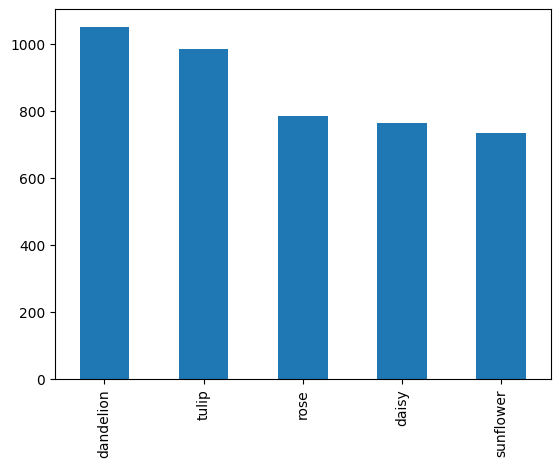

In [13]:
df['label'].value_counts().plot(kind='bar')

In [14]:
df['label'] = df['label'].map(label_dict)

In [15]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [17]:
train_dataset = FlowerDataset(train, transform=data_transforms['train'])
test_dataset = FlowerDataset(test, transform=data_transforms['val'])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
model = ConvNet()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
criteria = nn.CrossEntropyLoss()

In [22]:
# Train the model
try:
    model.load_state_dict(torch.load('saved_model/model.pt')) 
    print("saved model found")
except: 
    total_step = len(train_loader)
    num_epochs = 10
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Run the forward pass
            outputs = model(images)
            loss = criteria(outputs, labels)
            
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    torch.save(model.state_dict(), 'saved_model/model.pt')

                   

saved model found


In [23]:
# evaluate the model 
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the test images: 71.29629629629629 %


In [24]:
def predict_one_image(image_path, model):
    model.eval()
    image = Image.open(image_path)
    image = data_transforms['val'](image)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted


# predict one image
image_path = 'data/sunflower/14741813110_94964c39e2_n.jpg'
pred = predict_one_image(image_path, model)
 
print('Predicted class: {}'.format(flower[pred]))

Predicted class: sunflower


### Using transfer learning

In [25]:
model_resnet = convResnet()

c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.0001)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model_resnet = model_resnet.to(device)

In [29]:
# train the model 
try:
    model_resnet.load_state_dict(torch.load('saved_model/model_baseresnet_flower.pt'))
    print('model loaded')
except:
    print('model not found')
    print('training model')
    total_step = len(train_loader)
    num_epochs = 5
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Run the forward pass
            outputs = model_resnet(images)
            loss = criteria(outputs, labels)
            
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    torch.save(model_resnet.state_dict(), 'saved_model/model_baseresnet_flower.pt')

model loaded


In [30]:
# test the model accuracy
model_resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 90.97222222222223 %
